In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pylab as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

### Balance of the Dataset
- it gives a baseline accuracy score
    - the simplest classifier that predicts class 0 to all points is correct 75.9% of the time
    - a classification model has predictive power if it is  more accurate than the baseline
- it can guide what evaluation metric should be used
- <mark> For this project, we still use accuracy score to evaluate the model </mark>

False    0.845255
True     0.154745
Name: Revenue, dtype: float64


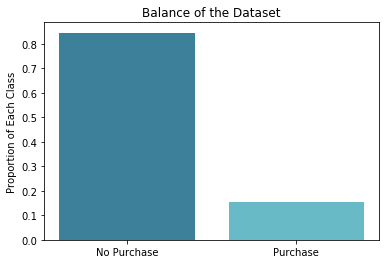

In [45]:
# Load the data
df = pd.read_csv("../data/online_shoppers_intention.csv")
label = 'Revenue'
print(df[label].value_counts()/df[label].shape)
plt.bar(['No Purchase', 'Purchase'], df.Revenue.value_counts(normalize=True), color=sns.color_palette("GnBu_d", n_colors=2))
plt.title('Balance of the Dataset')
plt.ylabel('Proportion of Each Class')
plt.show();

In [46]:
# Drop the missing data
df = df.dropna(axis=0) # axis = 1: drop the columns, axis = 0: drop the rows
df.reset_index(drop=True, inplace=True)

# Features
feature_names = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
                 'ProductRelated_Duration','BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
                'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend']
cat_ftrs = ['OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']
cont_ftrs = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
             'ProductRelated_Duration','PageValues']
perct_features = ['BounceRates','ExitRates']
ord_features = ['Month','SpecialDay']

In [47]:
# Preprocess the target variable
y = LabelEncoder().fit_transform(df[label])
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

   Administrative  Administrative_Duration  Informational  \
0             0.0                      0.0            0.0   
1             0.0                      0.0            0.0   
2             0.0                     -1.0            0.0   
3             0.0                      0.0            0.0   
4             0.0                      0.0            0.0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0             1.0                 0.000000   
1                     0.0             2.0                64.000000   
2                    -1.0             1.0                -1.000000   
3                     0.0             2.0                 2.666667   
4                     0.0            10.0               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

## Cross Validation and Machine Learning Pipeline:

In [72]:
print('test baseline = ',np.sum(y_test == 0)/len(y_test));
print(np.logspace(-2, 2,num=5))

test baseline =  0.8449675324675324
[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


### SVC

In [51]:
def ML_pipeline_kfold_GridSearchCV_svc(X,y,random_state,n_folds, cm_dict):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']
    cont_ftrs = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
             'ProductRelated_Duration','PageValues']
    ordinal_ftrs = ['Month','SpecialDay']
    ordinal_cats = [['Feb', 'Mar', 'May', 'June','Jul','Aug','Sep','Oct','Nov','Dec'],['0.0','0.2','0.4', '0.6','0.8', '1.0']]
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # ordinal scalar
    ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
    
    # Final Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs),
            ('ordinal', ordinal_transformer, ordinal_ftrs)])
    
    pipe = make_pipeline(preprocessor,SVC())
    
    # the parameter(s) we want to tune
    param_grid = {'svc__C': np.logspace(-1, 3, num=5),
                  'svc__gamma': np.logspace(-2, 2,num=5)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, scoring = make_scorer(accuracy_score), return_train_score = True, iid=True , n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    y_pred = grid.predict(X_test)
       
    # Confusion Matrix
    cm = confusion_matrix(y_test,y_pred)
#     DR = cm[1,1] / (cm[1,0] + cm[1,1])
#     FAR = cm[0,1] / (cm[0,0] + cm[0,1])
#     MIR = 1 - DR
#     TNR = 1 - FAR

    DR = cm[1,1]
    FAR = cm[0,1]
    MIR = cm[1,0]
    TNR = cm[0,0]
    cm_dict["Detection Rate"] += DR
    cm_dict["False Alarm Rate"] += FAR
    cm_dict["Miss Rate"] += MIR
    cm_dict["True Negative Rate"] += TNR
    
    return grid, grid.score(X_test, y_test), X_test, y_test

In [52]:
test_scores = []
cm_svc = {"Detection Rate":0, "False Alarm Rate":0, "Miss Rate":0, "True Negative Rate":0}
for i in range(1,11):
    grid, score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_svc(X,y,42*i,4,cm_svc) 
    print('random_state', 42*i)
    print('best_score', grid.best_score_)
    print('best_parameter',grid.best_params_)
    test_scores.append(grid.best_score_)
print("SVM's mean & std of accuracy is ",np.around(np.mean(test_scores),4), '+/-', np.around(np.std(test_scores),4))

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.9min finished


random_state 42
best_score 0.8946406820950061
best_parameter {'svc__C': 10.0, 'svc__gamma': 0.01}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished


random_state 84
best_score 0.8936256597645148
best_parameter {'svc__C': 10.0, 'svc__gamma': 0.01}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished


random_state 126
best_score 0.8916971173365814
best_parameter {'svc__C': 1.0, 'svc__gamma': 0.1}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished


random_state 168
best_score 0.8927121396670726
best_parameter {'svc__C': 1.0, 'svc__gamma': 0.1}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished


random_state 210
best_score 0.8943361753958587
best_parameter {'svc__C': 1.0, 'svc__gamma': 0.1}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.9min finished


random_state 252
best_score 0.8934226552984166
best_parameter {'svc__C': 10.0, 'svc__gamma': 0.01}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished


random_state 294
best_score 0.8952496954933008
best_parameter {'svc__C': 1.0, 'svc__gamma': 0.1}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.1min finished


random_state 336
best_score 0.8927121396670726
best_parameter {'svc__C': 100.0, 'svc__gamma': 0.01}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished


random_state 378
best_score 0.890580592773041
best_parameter {'svc__C': 1.0, 'svc__gamma': 0.1}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished


random_state 420
best_score 0.8917986195696306
best_parameter {'svc__C': 10.0, 'svc__gamma': 0.01}
SVM's mean & std of accuracy is  0.8931 +/- 0.0014


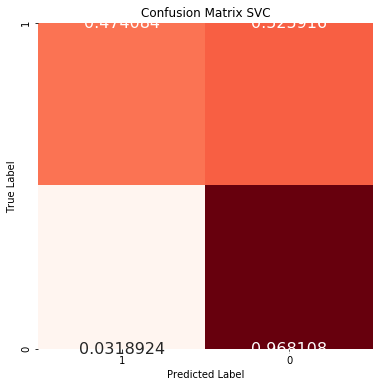

,1,0
1,0.474084,0.525916
0,0.031892,0.968108


In [66]:
def calculate_confusion(cm, name): # function for drawing and calculating confusion matrix
    total = sum(cm_svc.values())
    
    cm_df = pd.DataFrame([[cm["Detection Rate"]/(cm["Detection Rate"]+cm["Miss Rate"]),cm["Miss Rate"]/(cm["Detection Rate"]+cm["Miss Rate"])],
                          [cm["False Alarm Rate"]/(cm["False Alarm Rate"]+cm["True Negative Rate"]), cm["True Negative Rate"]/(cm["False Alarm Rate"]+cm["True Negative Rate"])]],
                         index=[1, 0], columns = [1, 0])
    
    plt.figure(figsize = (6,6))
    plt.title(f"Confusion Matrix {name}")
    sns.heatmap(cm_df, annot=True, fmt='g', cbar=False, 
               annot_kws={"size": 16}, cmap="Reds")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig('../figures/Confusion Matrix {name}.png',dpi=100)
    plt.show()
    return cm_df
calculate_confusion(cm_svc, 'SVC')

### Random Forest

In [19]:
def ML_pipeline_kfold_GridSearchCV_rf(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']
    cont_ftrs = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
             'ProductRelated_Duration','PageValues']
    ordinal_ftrs = ['Month','SpecialDay']
    ordinal_cats = [['Feb', 'Mar', 'May', 'June','Jul','Aug','Sep','Oct','Nov','Dec'],['0.0','0.2','0.4', '0.6','0.8', '1.0']]
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # ordinal scalar
    ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
    
    # Final Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs),
            ('ordinal', ordinal_transformer, ordinal_ftrs)])
    
    pipe = make_pipeline(preprocessor,RandomForestClassifier())
    # the parameter(s) we want to tune
    param_grid = {'randomforestclassifier__max_depth': [8, 11, 30, 50, 100],
                  'randomforestclassifier__min_samples_split': [8, 16, 32, 64, 128]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, scoring = make_scorer(accuracy_score), return_train_score = True, iid=True , n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
#     y_pred = grid.predict(X_test)
#     fpr, tpr, threshold = roc_curve(y_test, grid.predict_proba(X_test)[:,1])
    return grid, grid.score(X_test, y_test), X_test, y_test

In [20]:
test_scores = []
for i in range(1,11):
    grid, score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_rf(X,y,42*i,4) 
    print('random_state', 42*i)
    print('best_score', grid.best_score_)
    print('best_parameter',grid.best_params_)
    test_scores.append(grid.best_score_)
print("Random Forest's mean & std of accuracy is ",np.around(np.mean(test_scores),4), '+/-', np.around(np.std(test_scores),4))

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1332s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBacken

random_state 42
best_score 0.8943361753958587
best_parameter {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_split': 16}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1164s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


random_state 84
best_score 0.8941331709297604
best_parameter {'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_split': 32}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1164s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


random_state 126
best_score 0.8958587088915956
best_parameter {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_split': 32}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1259s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


random_state 168
best_score 0.8927121396670726
best_parameter {'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_split': 32}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1276s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


random_state 210
best_score 0.8925091352009744
best_parameter {'randomforestclassifier__max_depth': 100, 'randomforestclassifier__min_samples_split': 64}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1123s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


random_state 252
best_score 0.8928136419001218
best_parameter {'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_split': 16}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1209s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


random_state 294
best_score 0.8920016240357288
best_parameter {'randomforestclassifier__max_depth': 100, 'randomforestclassifier__min_samples_split': 32}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1239s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


random_state 336
best_score 0.891392610637434
best_parameter {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_split': 8}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1106s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


random_state 378
best_score 0.8910881039382866
best_parameter {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_split': 32}
Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1077s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.5s


random_state 420
best_score 0.8940316686967114
best_parameter {'randomforestclassifier__max_depth': 50, 'randomforestclassifier__min_samples_split': 64}
Random Forest's mean & std of accuracy is  0.8931 +/- 0.0014


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
df = pd.read_csv('data/true_labels_pred_probs.csv')
print(df.columns)
y_true = df['y_true'].values
pred_proba = df['pred_prob_class1'].values

y_pred = np.zeros(len(pred_proba),dtype=int)
y_pred[pred_proba < 0.5] = 0
y_pred[pred_proba >= 0.5] = 1

plot_confusion_matrix(y_true,y_pred,classes=['class 0', 'class 1'])
plt.show()

In [ ]:
# best_score 0.6040753895971125
# best_parameter {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_split': 20}

### Logistic Regression

In [27]:
LogisticRegression.get_params(LogisticRegression).keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [35]:
def ML_pipeline_kfold_GridSearchCV_logistic(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']
    cont_ftrs = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
             'ProductRelated_Duration','PageValues']
    ordinal_ftrs = ['Month','SpecialDay']
    ordinal_cats = [['Feb', 'Mar', 'May', 'June','Jul','Aug','Sep','Oct','Nov','Dec'],['0.0','0.2','0.4', '0.6','0.8', '1.0']]
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # ordinal scalar
    ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
    
    # Final Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs),
            ('ordinal', ordinal_transformer, ordinal_ftrs)])
    
    pipe = make_pipeline(preprocessor,LogisticRegression())
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__penalty': ['l1', 'l2'],
                  'logisticregression__C': np.logspace(0, 4, 10)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, scoring = make_scorer(accuracy_score), return_train_score = True, iid=True , n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test), X_test, y_test

In [73]:
np.logspace(0, 4, 10)

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

In [36]:
test_scores = []
for i in range(1, 11):
    grid, score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_logistic(X,y,42*i,4)  
    print('best_score', grid.best_score_)
    print('best_parameter',grid.best_params_)
    test_scores.append(grid.best_score_)
print("Logistic Regression's mean & std of accuracy is ",np.around(np.mean(test_scores),4), '+/-', np.around(np.std(test_scores),4))

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   23.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8843889565570443
best_parameter {'logisticregression__C': 2.7825594022071245, 'logisticregression__penalty': 'l2'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   23.9s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.880125862768981
best_parameter {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   25.8s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8811408850994722
best_parameter {'logisticregression__C': 7.742636826811269, 'logisticregression__penalty': 'l2'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   23.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8821559074299634
best_parameter {'logisticregression__C': 2.7825594022071245, 'logisticregression__penalty': 'l1'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   21.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8813438895655704
best_parameter {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   23.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8795168493706862
best_parameter {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   24.2s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8836784409257004
best_parameter {'logisticregression__C': 2.7825594022071245, 'logisticregression__penalty': 'l1'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   25.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8811408850994722
best_parameter {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   26.0s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8798213560698336
best_parameter {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   24.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


best_score 0.8821559074299634
best_parameter {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}
Logistic Regression's mean & std of accuracy is  0.8815 +/- 0.0015


### KNNeighbors

In [21]:
from sklearn.neighbors import KNeighborsClassifier
KNeighborsClassifier.get_params(KNeighborsClassifier).keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [37]:
def ML_pipeline_kfold_GridSearchCV_knn(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state, stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']
    cont_ftrs = ['Administrative', 'Administrative_Duration', 'Informational','Informational_Duration', 'ProductRelated', 
             'ProductRelated_Duration','PageValues']
    ordinal_ftrs = ['Month','SpecialDay']
    ordinal_cats = [['Feb', 'Mar', 'May', 'June','Jul','Aug','Sep','Oct','Nov','Dec'],['0.0','0.2','0.4', '0.6','0.8', '1.0']]
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # ordinal scalar
    ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
    
    # Final Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs),
            ('ordinal', ordinal_transformer, ordinal_ftrs)])
    
    pipe = make_pipeline(preprocessor,KNeighborsClassifier())
    # the parameter(s) we want to tune
    param_grid = {'kneighborsclassifier__weights': ['uniform', 'distance'],
                  'kneighborsclassifier__n_neighbors': [10,20,30,40,50,60]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, scoring = make_scorer(accuracy_score), return_train_score = True, iid=True , n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test), X_test, y_test

In [38]:
test_scores = []
for i in range(1, 11):
    grid, score, X_test, y_test = ML_pipeline_kfold_GridSearchCV_knn(X,y,42*i,4)  
    print('best_score', grid.best_score_)
    print('best_parameter',grid.best_params_)
    test_scores.append(grid.best_score_)
print("Random Forest's mean & std of f1 is ",np.around(np.mean(test_scores),4), '+/-', np.around(np.std(test_scores),4))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


best_score 0.876979293544458
best_parameter {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'distance'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


best_score 0.8761672756800649
best_parameter {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'distance'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


best_score 0.8757612667478685
best_parameter {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'uniform'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.5min finished


best_score 0.88022736500203
best_parameter {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.5min finished


best_score 0.8764717823792123
best_parameter {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'uniform'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.3min finished


best_score 0.8753552578156719
best_parameter {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'distance'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


best_score 0.8775883069427527
best_parameter {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'uniform'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


best_score 0.8771822980105562
best_parameter {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'distance'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


best_score 0.8755582622817702
best_parameter {'kneighborsclassifier__n_neighbors': 30, 'kneighborsclassifier__weights': 'uniform'}
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.4min finished


best_score 0.8785018270401949
best_parameter {'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__weights': 'distance'}
Random Forest's mean & std of f1 is  0.877 +/- 0.0014


### Permutation feature importance - Global 

In [62]:
nr_runs = 10
scores = np.zeros([len(feature_names),nr_runs])
test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(feature_names)):
    print('shuffling '+ str(feature_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[feature_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8912337662337663
test baseline =  0.8449675324675324
shuffling Administrative
   shuffled test score: 0.889 +/- 0.001
shuffling Administrative_Duration
   shuffled test score: 0.891 +/- 0.001
shuffling Informational
   shuffled test score: 0.891 +/- 0.001
shuffling Informational_Duration
   shuffled test score: 0.892 +/- 0.0
shuffling ProductRelated
   shuffled test score: 0.891 +/- 0.001
shuffling ProductRelated_Duration
   shuffled test score: 0.891 +/- 0.001
shuffling BounceRates
   shuffled test score: 0.891 +/- 0.0
shuffling ExitRates
   shuffled test score: 0.891 +/- 0.0
shuffling PageValues
   shuffled test score: 0.765 +/- 0.005
shuffling SpecialDay
   shuffled test score: 0.891 +/- 0.001
shuffling Month
   shuffled test score: 0.89 +/- 0.002
shuffling OperatingSystems
   shuffled test score: 0.893 +/- 0.001
shuffling Browser
   shuffled test score: 0.891 +/- 0.001
shuffling Region
   shuffled test score: 0.891 +/- 0.001
shuffling TrafficType
   shuffled test sc

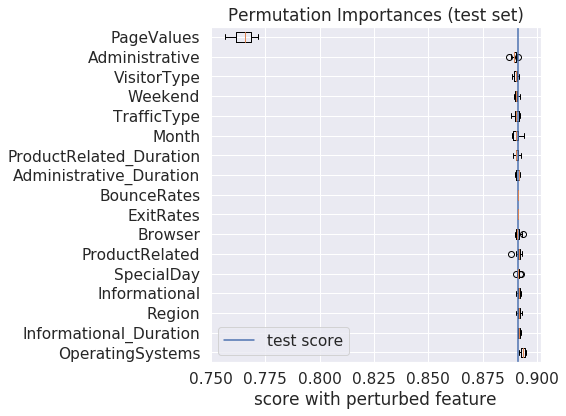

In [74]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
label = [feature_names[x] for x in sorted_indcs]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=label,vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/permutation_importance.png', bbox_inches = 'tight')
plt.show()

### Sampling balance data from imbalanced data - Possible Approach

<https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets>

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).